In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet
from sklearn.model_selection import train_test_split

2023-04-07 21:57:23.983148: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [6]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [7]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

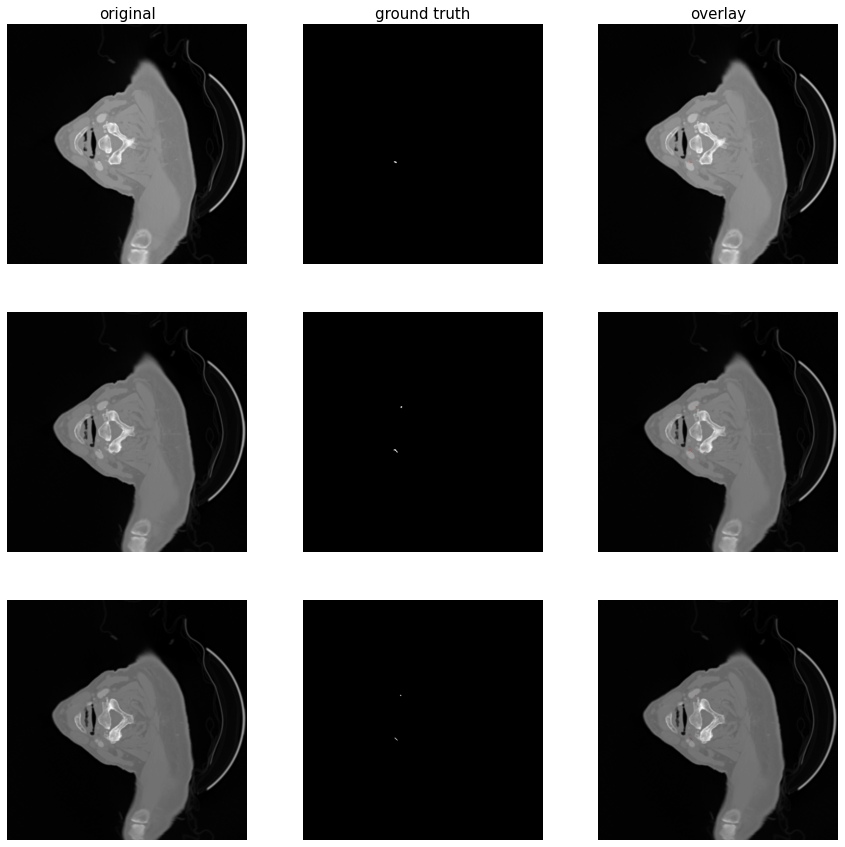

In [8]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

In [11]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=32, #original: 64 next:128
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-04-07 21:57:28.426484: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-07 21:57:28.569751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-07 21:57:28.569791: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-07 21:57:28.569827: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-07 21:57:28.569844: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-07 21:57:28.570792: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2023-04-07 21:57:28.578080: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 21:57:28.580756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-07 21:57:28.585868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-04-07 21:57:28.585894: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-07 21:57:29.054882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecuto

In [12]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr = 0.001),
              metrics=[iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [15]:
history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-04-07 21:57:47.781558: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-07 21:57:47.801236: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-04-07 21:58:12.536398: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-07 21:58:13.383480: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-07 21:58:13.383838: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-07 21:58:13.488709: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-07 21:58:13.635124: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-04-07 21:58:14.086694: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-07 21:58:14.086720: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-07 21:58:14.08678

39/39 [==============================] - 55s 729ms/step - loss: 0.0560 - iou: 0.0012 - iou_thresholded: 0.0014 - val_loss: 0.0037 - val_iou: 0.0012 - val_iou_thresholded: 0.0013
Epoch 2/200
39/39 [==============================] - 23s 600ms/step - loss: 0.0027 - iou: 0.0010 - iou_thresholded: 0.0014 - val_loss: 0.0025 - val_iou: 8.4861e-04 - val_iou_thresholded: 0.0013
Epoch 3/200
39/39 [==============================] - 23s 597ms/step - loss: 0.0019 - iou: 0.0011 - iou_thresholded: 0.0014 - val_loss: 0.0019 - val_iou: 0.0012 - val_iou_thresholded: 0.0013
Epoch 4/200
39/39 [==============================] - 23s 604ms/step - loss: 0.0016 - iou: 0.0016 - iou_thresholded: 0.0016 - val_loss: 0.0017 - val_iou: 0.0018 - val_iou_thresholded: 0.0013
Epoch 5/200
39/39 [==============================] - 23s 601ms/step - loss: 0.0015 - iou: 0.0023 - iou_thresholded: 0.0014 - val_loss: 0.0016 - val_iou: 0.0020 - val_iou_thresholded: 0.0013
Epoch 6/200
39/39 [==============================] - 23s 5

Epoch 43/200
39/39 [==============================] - 23s 600ms/step - loss: 2.4761e-04 - iou: 0.4184 - iou_thresholded: 0.5308 - val_loss: 5.2300e-04 - val_iou: 0.2854 - val_iou_thresholded: 0.3113
Epoch 44/200
39/39 [==============================] - 23s 601ms/step - loss: 2.3826e-04 - iou: 0.4301 - iou_thresholded: 0.5402 - val_loss: 4.5434e-04 - val_iou: 0.3233 - val_iou_thresholded: 0.3850
Epoch 45/200
39/39 [==============================] - 23s 603ms/step - loss: 2.3738e-04 - iou: 0.4295 - iou_thresholded: 0.5392 - val_loss: 4.4340e-04 - val_iou: 0.3349 - val_iou_thresholded: 0.4045
Epoch 46/200
39/39 [==============================] - 23s 599ms/step - loss: 2.3347e-04 - iou: 0.4387 - iou_thresholded: 0.5501 - val_loss: 4.6690e-04 - val_iou: 0.3199 - val_iou_thresholded: 0.3671
Epoch 47/200
39/39 [==============================] - 23s 598ms/step - loss: 2.1846e-04 - iou: 0.4567 - iou_thresholded: 0.5736 - val_loss: 4.7422e-04 - val_iou: 0.3239 - val_iou_thresholded: 0.3570
Epoch

39/39 [==============================] - 24s 608ms/step - loss: 9.5235e-05 - iou: 0.7108 - iou_thresholded: 0.8120 - val_loss: 4.9680e-04 - val_iou: 0.4403 - val_iou_thresholded: 0.4688
Epoch 85/200
39/39 [==============================] - 23s 601ms/step - loss: 8.9206e-05 - iou: 0.7216 - iou_thresholded: 0.8241 - val_loss: 5.0233e-04 - val_iou: 0.4425 - val_iou_thresholded: 0.4720
Epoch 86/200
39/39 [==============================] - 23s 603ms/step - loss: 8.2321e-05 - iou: 0.7392 - iou_thresholded: 0.8407 - val_loss: 5.0018e-04 - val_iou: 0.4516 - val_iou_thresholded: 0.4800
Epoch 87/200
39/39 [==============================] - 24s 606ms/step - loss: 8.1019e-05 - iou: 0.7416 - iou_thresholded: 0.8435 - val_loss: 5.2499e-04 - val_iou: 0.4416 - val_iou_thresholded: 0.4670
Epoch 88/200
39/39 [==============================] - 23s 600ms/step - loss: 8.2456e-05 - iou: 0.7419 - iou_thresholded: 0.8399 - val_loss: 5.3296e-04 - val_iou: 0.4429 - val_iou_thresholded: 0.4668
Epoch 89/200
39/39

39/39 [==============================] - 24s 603ms/step - loss: 3.9184e-05 - iou: 0.8610 - iou_thresholded: 0.9313 - val_loss: 6.6959e-04 - val_iou: 0.4628 - val_iou_thresholded: 0.4732
Epoch 126/200
39/39 [==============================] - 23s 603ms/step - loss: 4.1284e-05 - iou: 0.8613 - iou_thresholded: 0.9307 - val_loss: 6.7250e-04 - val_iou: 0.4652 - val_iou_thresholded: 0.4795
Epoch 127/200
39/39 [==============================] - 23s 602ms/step - loss: 4.0817e-05 - iou: 0.8600 - iou_thresholded: 0.9268 - val_loss: 6.7924e-04 - val_iou: 0.4639 - val_iou_thresholded: 0.4781
Epoch 128/200
39/39 [==============================] - 23s 600ms/step - loss: 4.3772e-05 - iou: 0.8568 - iou_thresholded: 0.9210 - val_loss: 7.2471e-04 - val_iou: 0.4543 - val_iou_thresholded: 0.4667
Epoch 129/200
39/39 [==============================] - 24s 605ms/step - loss: 4.5235e-05 - iou: 0.8538 - iou_thresholded: 0.9171 - val_loss: 6.9221e-04 - val_iou: 0.4613 - val_iou_thresholded: 0.4764
Epoch 130/200


39/39 [==============================] - 23s 600ms/step - loss: 0.0015 - iou: 0.0159 - iou_thresholded: 0.0124 - val_loss: 0.0028 - val_iou: 0.0016 - val_iou_thresholded: 0.0013
Epoch 168/200
39/39 [==============================] - 23s 601ms/step - loss: 0.0020 - iou: 0.0095 - iou_thresholded: 0.0068 - val_loss: 0.0017 - val_iou: 0.0114 - val_iou_thresholded: 0.0073
Epoch 169/200
39/39 [==============================] - 23s 599ms/step - loss: 0.0014 - iou: 0.0150 - iou_thresholded: 0.0107 - val_loss: 0.0016 - val_iou: 0.0155 - val_iou_thresholded: 0.0098
Epoch 170/200
39/39 [==============================] - 23s 596ms/step - loss: 0.0015 - iou: 0.0133 - iou_thresholded: 0.0113 - val_loss: 0.0018 - val_iou: 0.0074 - val_iou_thresholded: 0.0025
Epoch 171/200
39/39 [==============================] - 24s 604ms/step - loss: 0.0015 - iou: 0.0144 - iou_thresholded: 0.0116 - val_loss: 0.0016 - val_iou: 0.0117 - val_iou_thresholded: 0.0049
Epoch 172/200
39/39 [==============================] -

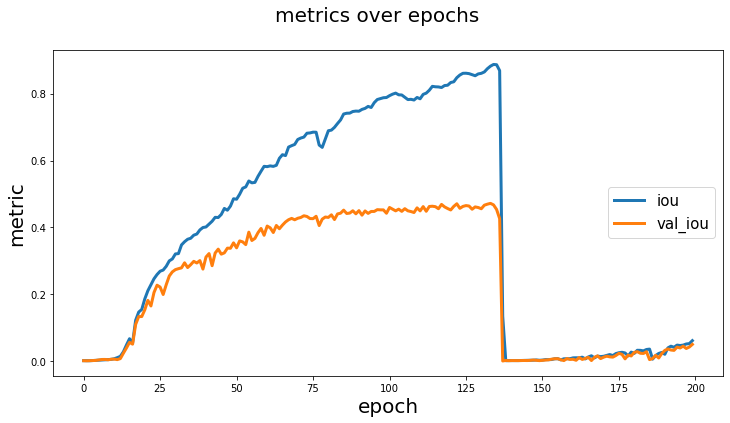

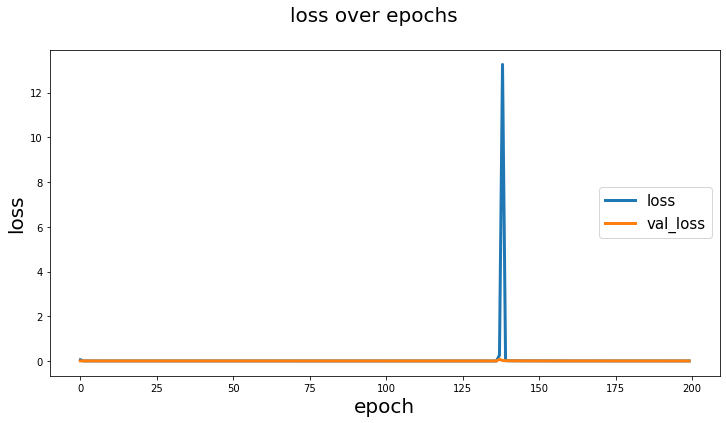

In [16]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [17]:
y_pred = model.predict(X_val)

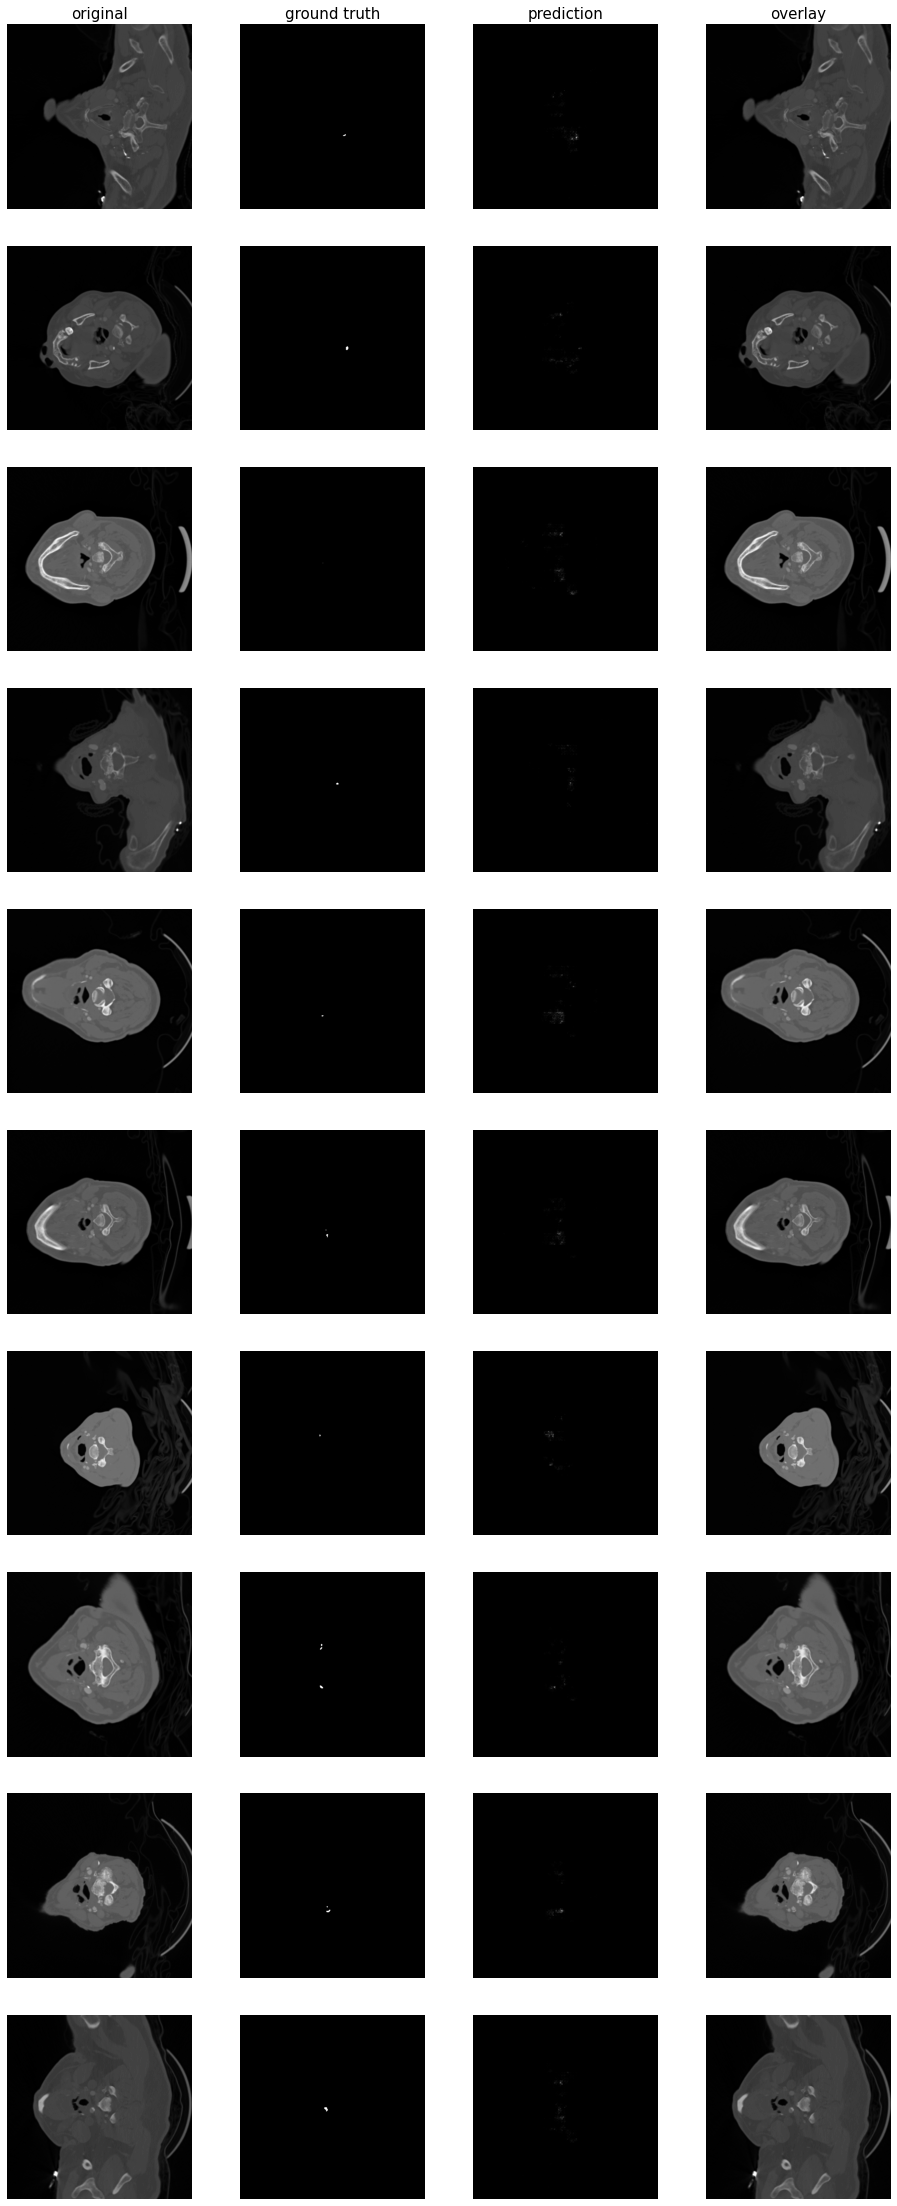

In [18]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [19]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

5/5 [==============================] - 2s 357ms/step - loss: 0.0011 - iou: 0.0524 - iou_thresholded: 0.0535
